In [1]:

from __future__ import print_function

import os
import sys
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, SpatialDropout1D, Dropout, BatchNormalization
from keras.models import Model
import pandas as pd
from matplotlib import pylab as plt
import tensorflow as tf
%matplotlib inline

Using TensorFlow backend.


In [2]:
BASE_DIR = ''
GLOVE_DIR = BASE_DIR + ''
TEXT_DATA_DIR = BASE_DIR + 'data\\'
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2


In [3]:
# first, build index mapping words in the embeddings set
# to their embedding vector

print('Indexing word vectors.')

embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.50d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found  %s word vectors.' % len(embeddings_index))


Indexing word vectors.
Found  400000 word vectors.


In [4]:
print(len(embeddings_index['word']), len(embeddings_index['football']))

50 50


In [5]:
# second, prepare text samples and their labels
data = pd.read_csv("vfeed.csv", sep="|")


C:\Users\aliex\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
#preparing a column data types
data['date_published'] = pd.to_datetime(data['date_published'])
data['date_modified'] = pd.to_datetime(data['date_modified'])
#data.replace(to_replace="not_defined", value=0, inplace=True)
#data.replace(to_replace="not_calculated", value=0, inplace=True)
#data[['cvss_base', 'cvss_impact', 'cvss_exploit']]= data[['cvss_base', 'cvss_impact', 'cvss_exploit']].apply(pd.to_numeric)


In [7]:
data_sum_cvss = data[['summary','cvss_base','cvss_impact','cvss_exploit']]
data_sum_cvss = data_sum_cvss[(data_sum_cvss.cvss_base != "not_defined")    & 
                              (data_sum_cvss.cvss_exploit != "not_defined") &
                              (data_sum_cvss.cvss_impact != "not_defined")  & 
                              (data_sum_cvss.cvss_base != "not_calculated") & 
                              (data_sum_cvss.cvss_exploit != "not_calculated") & 
                              (data_sum_cvss.cvss_impact != "not_calculated")]
targets = data_sum_cvss[['cvss_base','cvss_impact','cvss_exploit']].apply(pd.to_numeric)
texts = data_sum_cvss[['summary']]

In [8]:
targets=targets[:20000]
texts=texts[:20000]

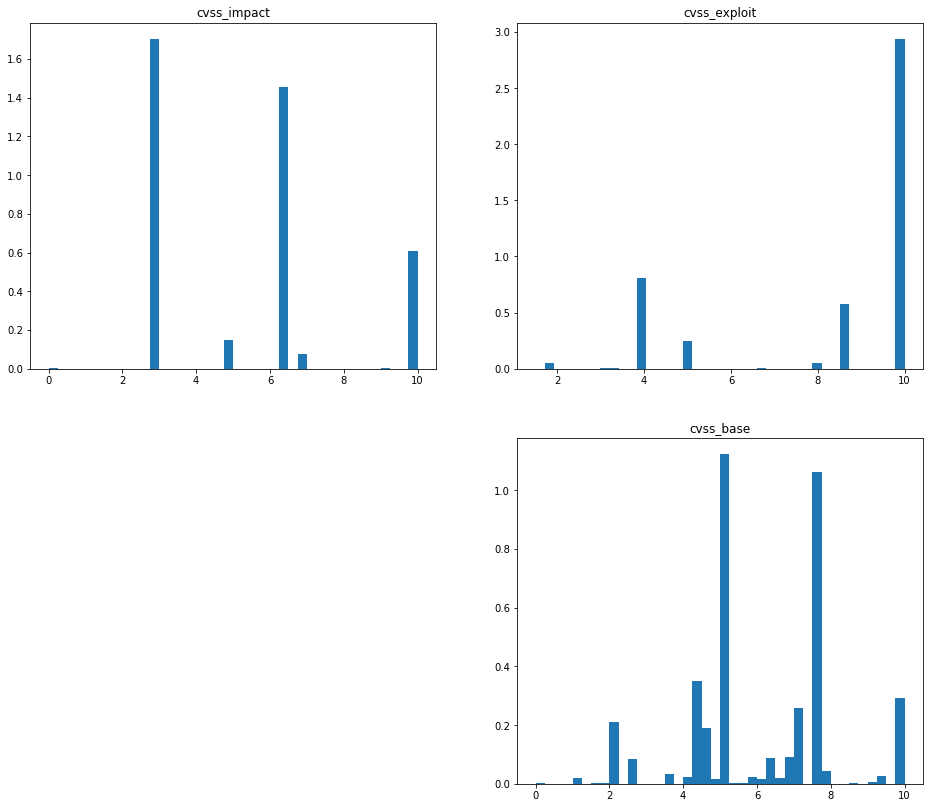

In [9]:
plt.figure(figsize=(16,14))
plt.subplot('220')
plt.hist(targets['cvss_base'], bins=40, normed=True)
plt.title('cvss_base')
plt.subplot('221')
plt.hist(targets['cvss_impact'], bins=40, normed=True)
plt.title('cvss_impact')
plt.subplot('222')
plt.hist(targets['cvss_exploit'], bins=40, normed=True)
plt.title('cvss_exploit')

In [10]:
targets = targets[['cvss_base','cvss_impact','cvss_exploit']].apply(round)

([<matplotlib.axis.XTick at 0x1bcad166e48>,
 <a list of 11 Text xticklabel objects>)

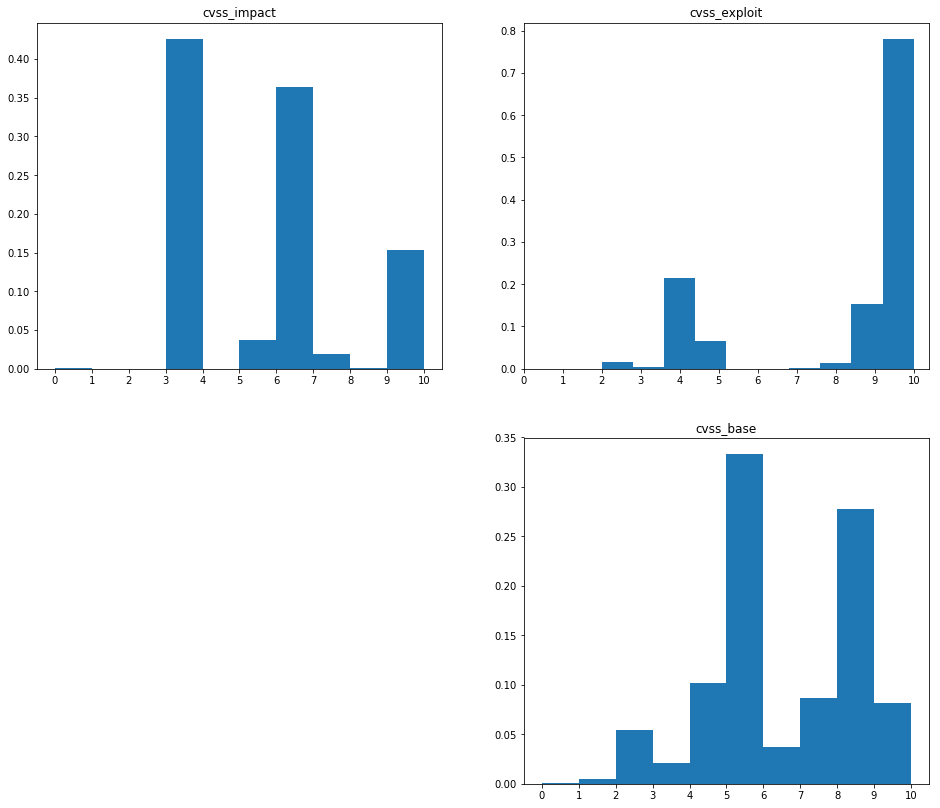

In [11]:
plt.figure(figsize=(16,14))
plt.subplot('220')
plt.hist(targets['cvss_base'], normed=True)
plt.title('cvss_base')
plt.xticks(np.arange(0,11))
plt.subplot('221')
plt.hist(targets['cvss_impact'], normed=True)
plt.title('cvss_impact')
plt.xticks(np.arange(0,11))
plt.subplot('222')
plt.hist(targets['cvss_exploit'], normed=True)
plt.title('cvss_exploit')
plt.xticks(np.arange(0,11))

In [12]:
list(texts['summary'])

['Multiple stack-based buffer overflows in the iriap_getvaluebyclass_indication function in net/irda/iriap.c in the Linux kernel before 2.6.39 allow remote attackers to cause a denial of service (memory corruption) or possibly have unspecified other impact by leveraging connectivity to an IrDA infrared network and sending a large integer value for a (1) name length or (2) attribute length.',
 'The cifs_find_smb_ses function in fs/cifs/connect.c in the Linux kernel before 2.6.36 does not properly determine the associations between users and sessions, which allows local users to bypass CIFS share authentication by leveraging a mount of a share by a different user.',
 'A certain Red Hat patch to the sctp_sock_migrate function in net/sctp/socket.c in the Linux kernel before 2.6.21, as used in Red Hat Enterprise Linux (RHEL) 5, allows remote attackers to cause a denial of service (NULL pointer dereference and OOPS) via a crafted SCTP packet.',
 'The perf subsystem in the kernel package 2.6.

In [13]:
# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts['summary'])


In [14]:
sequences = tokenizer.texts_to_sequences(texts['summary'])

In [15]:
len(sequences)

20000

In [16]:
word_index = tokenizer.word_index
print('Found %s tokens.' % len(word_index))

pad_seq = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)


Found 27009 tokens.


In [17]:
#labels = to_categorical(np.asarray(targets['cvss_base']))
labels = np.asarray(targets['cvss_base'])
#labels_fname = np.asarray(labels_fname)
print('Objects:', pad_seq.shape)
print('Labels:', labels.shape)
#print('Labels_fname:', labels_fname.shape)


Objects: (20000, 1000)
Labels: (20000,)


In [18]:
def round_delimiter(arr, d):
    answ = []
    for x in arr:
        answ.append(1 if int(x) > d else 0)
    return answ

labels_5_not_cat = np.asarray(round_delimiter( labels, 7.5 ))

In [19]:
labels_5 = to_categorical(labels_5_not_cat)

In [20]:
#shuffle data
indices = np.arange(pad_seq.shape[0])
np.random.shuffle(indices)
pad_seq = pad_seq[indices]
labels = labels[indices]
labels_5 = labels_5[indices]
num_validation_samples = int(VALIDATION_SPLIT * pad_seq.shape[0])


In [21]:
# split the data into a training set and a validation set
x_train = pad_seq[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = pad_seq[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

y_train_5 = labels_5[:-num_validation_samples]
y_val_5 = labels_5[-num_validation_samples:]

#y_train = labels[:-num_validation_samples]


In [22]:
print('Preparing embedding matrix.')

# prepare embedding matrix
num_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:

        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

Preparing embedding matrix.


In [23]:

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [24]:
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape, len(labels))
#print(labels.shape[1])
print(num_words)
print(y_train[1])

(16000, 1000) (16000,) (4000, 1000) (4000,) 20000
20000
2.0


In [25]:
print('Training model.')
# train a 1D convnet with global maxpooling
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)


Training model.


In [26]:
from sklearn.metrics import roc_curve, auc
from keras import backend as K

def sklearnAUC(val_labels,val_prediction):
    n_classes = 2
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        # ( actual labels, predicted probabilities )
        fpr[i], tpr[i], _ = roc_curve(val_labels[:, i], val_prediction[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    return round(roc_auc[0],3) , round(roc_auc[1],3)

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))
 

#-----------------------------------------------------------------------------------------------------------------------------------------------------
# AUC for a binary classifier
def auc(y_true, y_pred):   
    ptas = tf.stack([binary_PTA(y_true,y_pred,k) for k in np.linspace(0, 1, 1000)],axis=0)
    pfas = tf.stack([binary_PFA(y_true,y_pred,k) for k in np.linspace(0, 1, 1000)],axis=0)
    pfas = tf.concat([tf.ones((1,)) ,pfas],axis=0)
    binSizes = -(pfas[1:]-pfas[:-1])
    s = ptas*binSizes
    return K.sum(s, axis=0)

#-----------------------------------------------------------------------------------------------------------------------------------------------------
# PFA, prob false alert for binary classifier
def binary_PFA(y_true, y_pred, threshold=K.variable(value=0.5)):
    y_pred = K.cast(y_pred >= threshold, 'float32')
    # N = total number of negative labels
    N = K.sum(1 - y_true)
    # FP = total number of false alerts, alerts from the negative class labels
    FP = K.sum(y_pred - y_pred * y_true)    
    return FP/N
#-----------------------------------------------------------------------------------------------------------------------------------------------------
# P_TA prob true alerts for binary classifier
def binary_PTA(y_true, y_pred, threshold=K.variable(value=0.5)):
    y_pred = K.cast(y_pred >= threshold, 'float32')
    # P = total number of positive labels
    P = K.sum(y_true)
    # TP = total number of correct alerts, alerts from the positive class labels
    TP = K.sum(y_pred * y_true)    
    return TP/P

# gives a numpy array like so [ [0.3,0.7] , [0.2,0.8] ....]    
#Y_pred = model.predict_on_batch ( X_test  ) 
# Y_test looks something like [ [0,1] , [1,0] .... ]
# auc1 and auc2 should be equal
#auc1, auc2 = sklearnAUC(Y_test, Y_pred)

In [27]:
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(35)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(labels.shape[1], activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc', auc])

model.fit(x_train, y_train,
          batch_size=128,
          epochs=10
          ,validation_data=(x_val, y_val))
model.save('model_glove50_rmsprop.ml')

IndexError: tuple index out of range

In [28]:
dropout = 0.4
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = SpatialDropout1D(dropout) (x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = SpatialDropout1D(dropout) (x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = SpatialDropout1D(dropout) (x)
x = MaxPooling1D(35)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(dropout) (x)
x = BatchNormalization() (x)
x = Dense(128, activation='relu')(x)
x = Dropout(dropout) (x)
x = BatchNormalization() (x)
x = Dense(128, activation='relu')(x)
x = Dropout(dropout) (x)
x = BatchNormalization() (x)
preds = Dense(2, activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
    #loss='categorical_hinge',
              optimizer='adam',
              metrics=['acc',auc])

model.fit(x_train, y_train_5,
          batch_size=128,
          epochs=20
          ,validation_data=(x_val, y_val_5))
model.save('model_glove50_adam_5.ml')

Train on 16000 samples, validate on 4000 samples
Epoch 1/20
16000/16000 [==============================] - 78s 5ms/step - loss: 0.8240 - acc: 0.5630 - auc: 0.5738 - val_loss: 0.6629 - val_acc: 0.6240 - val_auc: 0.6178

In [ ]:
preds = model.predict(x_val)

In [ ]:
target_5 = 

In [ ]:
preds_max = [np.argmax(arr) for arr in preds]
len(preds_max)

In [ ]:
plt.hist(preds_max)

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')
